In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-4

# <u> MelGAN's Generator</u>
### (MelGAN: Generative Adversarial Networks for Conditional Waveform Synthesis, Kumar et. al 2019) ###
https://arxiv.org/pdf/1910.06711.pdf
https://github.com/descriptinc/melgan-neurips

The problem this model is addressing here, is the one of **Text-To-Speech (TTS)** synthesis. This can either be solved with an end-to-end (E2E) model, or by breaking it into two parts:

![Topic](fig/topic.png)
![](https://drive.google.com/uc?export=view&id=1c-AHn6Ihcu5jxvDn1W9oUx1yJkgRe9xz)  
We will focus on the second part, i.e., from speech features to speech waves, and the vocoder will be a neural network model (can be generative or not). Here, our speech features will be **Mel-Spectrograms**. We will not explain them in this tutorial because it is out of our topic. In a crude summary, they are compressed forms of traditional (linear) spectrograms. Even if you do not know what spectrograms are, you can think of them as a time series of amplitude responses, meaning that the x-axis represents time, and the y-axis represents frequency. <br>
As its name suggests, MelGAN is a Generative Adversarial Network (GAN), but since we have not talked about GANs yet, we will just focus on MelGAN's Generator network, i.e., the one responsible for the Mel-to-speech transformation. As a whole, MelGAN is a very successful model because it strikes a great balance between computational and spacial costs, audio fidelity, and inference speed, hence, it has recently found its place also in the industry.

In [ ]:
from librosa.filters import mel as librosa_mel_fn  # pip install librosa
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import librosa
import random
import os

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader

device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

### <u> DSP Hyperparameters & Mel-Spectrogram</u> ###

+ fs = Sampling frequency in Hz.
+ seq_len = Defined audio sequence length in samples to train the network. These will be transformed into Mel-Spectrograms before they are fed into the Generator.
+ no_mels = Number of Mel frequency bins of the Mel-Spectrogram. This will be the length of the y-axis of the Mel-Spectrogram.
+ win_length = The length of the (hanning) window in samples to create the Mel-Spectrogram.
+ hop_length = How many samples we shift the window each time. Each shift (or hop) will generate no_mels samples. So, seq_len//hop_length is the number of hops that fit in seq_len.
+ input_shape = The actual input shape fed into the network. It will be 2D: y-axis will be of length no_mels, and x-axis of seq_len//hop_length.


In [ ]:
fs = 22050
seq_len = 8192  # (~0.37 seconds)
no_fft = 1024
win_length = 1024
hop_length = 256
no_mels = 80
input_shape = (no_mels, seq_len//hop_length)

When MelGAN was launched, the class `torchaudio.transforms.MelSpectrogram` did not exist, so we had to manually create a class to convert a raw audio signal to a Mel-Spectrogram. Remember that we need to do that in PyTorch for speed, allow differentiability if needed, or data loading:

In [ ]:
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=no_fft,
        hop_len=hop_length,
        win_len=win_length,
        sr=fs,
        n_mel_channels=no_mels,
        mel_fmin=0.0,
        mel_fmax=fs/2,
    ):
        super().__init__()
        ##############################################
        # FFT Parameters                             #
        ##############################################
        window = tc.hann_window(win_len).float()
        mel_basis = librosa_mel_fn(
            sr=sr,
            n_fft=n_fft,
            n_mels=n_mel_channels,
            fmin=mel_fmin,
            fmax=mel_fmax
        )
        mel_basis = tc.from_numpy(mel_basis).float()

        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_len
        self.win_length = win_len
        self.sampling_rate = sr
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        stft = tc.stft(
            input=audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
            return_complex=True
        )
        magnitude = tc.sqrt(stft.real ** 2 + stft.imag ** 2)
        mel_output = tc.matmul(self.mel_basis, magnitude)
        log_mel_spec = tc.log10(tc.clamp(mel_output, min=1e-5))
        return log_mel_spec

Load a speech file:

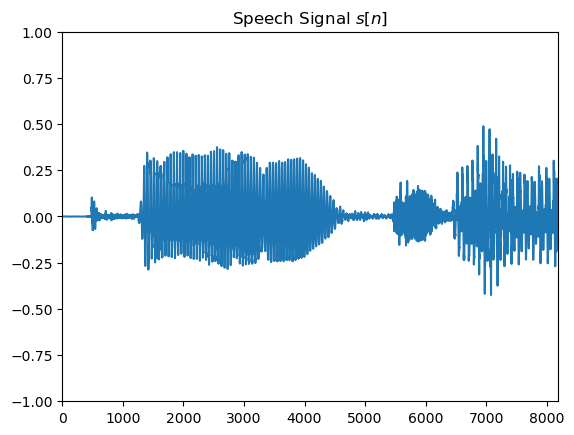

In [ ]:
wav_path = os.path.join('data', 'wav')

test_sigs = np.zeros(shape=(16, seq_len))
test_sig, sampling_rate = librosa.core.load(
    os.path.join(wav_path, "LJ001-0001.wav"), sr=fs
)
test_sigs[0] = test_sig[:seq_len]

plt.figure()
plt.plot(test_sigs[0])
plt.xlim([0, seq_len])
plt.ylim([-1, 1])
plt.title("Speech Signal $s[n]$")
plt.show()
plt.close()

Plot the corresponding Mel-Spectrogram and input-output shapes to see that it is working as intended:

Input shape (time domain) = torch.Size([16, 8192])
Output shape (mel domain) = torch.Size([16, 80, 32])


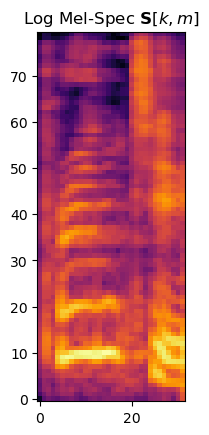

In [ ]:
test_sigs = tc.from_numpy(test_sigs).to(device=device, dtype=tc.float32)

mel = Audio2Mel().to(device)
print(f"Input shape (time domain) = {test_sigs.shape}")
melspecs = mel(test_sigs)
print(f"Output shape (mel domain) = {melspecs.shape}")

plt.figure()
plt.plot()
plt.imshow(melspecs[0].cpu(), cmap="inferno")
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.title("Log Mel-Spec $\mathbf{S}[k, m]$")
plt.show()
plt.close()

### <u> Weight Distribution Initialization</u>

The distribution choice for weight initialization is often neglected, but influences the convergence rate of the network, and can help prevent gradient issues that can occur with poorly chosen initial weights. Well-chosen initial weights can also lead to a more symmetric and efficient distribution of activations across the layers, enabling the network to learn more complex patterns more quickly.
https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1
In this case, it turns out that the normal distribution is a better alternative than the default (i.e., uniform):

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)

### <u>Weight Normalization (Salimans, Kingma, 2016)</u>
https://arxiv.org/pdf/1602.07868.pdf <br>
The word "normalization" can be a somewhat misleading here in my opinion, in the sense that we do not normalize the weights in the sence of scaling them to a unit norm or adjusting them to have specific statistical properties. It is more like a decomposition rather than a normalization in the more traditional sense. <br>
Weight normalization is a technique introduced to improve the training of neural networks by reparameterizing the weights in a way that decouples the length of the weight vectors from their direction. This is achieved by separating the direction vector $\mathbf{v}$ and the scalar parameter $g$ from a weight vector $\mathbf{w}$: <br>
\begin{equation*}
\mathbf{w} = g \dfrac{\mathbf{v}}{||\mathbf{v}||},
\end{equation*}
where $||\mathbf{v}||$ is the Euclidian norm of $\mathbf{v}$, which is always 1, because $\mathbf{v}$ is essentially the unit vector of $\mathbf{w}$. Note that this introduces an additional training parameter, i.e., the scalar $g$. However, this practice aims to accelerate convergence of stochastic gradient descent optimization by addressing issues related to the scale of weights. Here is an example of the decoupling:

In [ ]:
# Assume we have these weights:
w = np.asarray([[0.6, -0.4, 0.2], [0.1, 0.03, -0.1]])
print(f"w =\n{w}, (old trainable param)")
# The decoupling will be:
g = np.sqrt(np.sum(w**2))
print(f"g = {g}, (new trainable param)")
v = w / g
print(f"v =\n{v}, (new trainable param)")
v_norm =  np.sqrt(np.sum(v**2))
print(f"||v|| = {v_norm},")
# Equal to w from the formula:
print(f"g*v/||v|| =\n{g*v/v_norm}.")

w =
[[ 0.6  -0.4   0.2 ]
 [ 0.1   0.03 -0.1 ]], (old trainable param)
g = 0.7621679604916491, (new trainable param)
v =
[[ 0.78722805 -0.5248187   0.26240935]
 [ 0.13120468  0.0393614  -0.13120468]], (new trainable param)
||v|| = 0.9999999999999999,
g*v/||v|| =
[[ 0.6  -0.4   0.2 ]
 [ 0.1   0.03 -0.1 ]].


Weight normalization will be used in all layers of the network. A good way to ensure it is to re-define our own layers with just weight normalization included:

In [ ]:
def wn_conv1d(*args, **kwargs):
    return nn.utils.parametrizations.weight_norm(nn.Conv1d(*args, **kwargs))

def wn_convtranspose1d(*args, **kwargs):
    return nn.utils.parametrizations.weight_norm(nn.ConvTranspose1d(*args, **kwargs))

### <u>Residual and Skip Connections</u> ###

This is an example of a residual connection that is used in MelGAN (note the input is added to the output):

<img src="fig/res_stack.png" />

![](https://drive.google.com/uc?export=view&id=13WJajT_DnzGeYyQIMrpx8eOOOaKagNsv)

Residual connections and skip connections are important and closely related concepts in the context of neural network architectures that are sometimes used interchangeably. Skip connections (introduced with the ResNet architecture) are used more broadly to refer to any architecture that allows information to bypass one or more layers directly. Residual connections, on the other hand, are a more specific type of skip connection: They refer to the architectural feature where the input to a layer (or a set of layers) is added to its output, effectively skipping at least one layer in between (as seen in the figure above). This allows the layers in between to learn residual functions, hence their name. <br>
Some benefits of skip/residual connections are:
+ Alleviating vanishing gradient issues: Gradients flow directly through the skip connections, so, bypassing layers preserves the gradient magnitude. This feature allows for the design of deeper architectures.
+ Less information loss: During training, layers can sometimes learn to filter out important information, so skip connections can help preserve this information from being lost. This is also true with respect to the gradient flow.
+ Simplifying optimization: Learning residual functions with respect to the layer inputs many times tends to be easier to optimize rather than learning unreferenced functions.

In [ ]:
# Leaky ReLU (negative) slope:
a = 0.2

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(a),
            nn.ReflectionPad1d(padding=dilation),
            wn_conv1d(
                in_channels=dim,
                out_channels=dim,
                kernel_size=3,
                dilation=dilation
            ),
            nn.LeakyReLU(a),
            wn_conv1d(
                in_channels=dim,
                out_channels=dim,
                kernel_size=1
            ),
        )

        self.shortcut = wn_conv1d(
            in_channels=dim,
            out_channels=dim,
            kernel_size=1
        )

    def forward(self, x):
        return self.shortcut(x) + self.block(x)

The above class will be used to create multiple residual blocks to make create a **residual stack**, which will be the primary parts of the network that progress the mel-to-speech transformation:

<img src="fig/res_stack_exp.png"/>

![](https://drive.google.com/uc?export=view&id=1km2DYaa3IP1o2BjEtPdbtd7HCCIEo41C)


## <u>Generator Architecture</u>

Goal: Create a fully convolutional architecture to learn the transform $\mathcal{T}\ \{\mathbf{S}[k]\} = s[n]$, where $S$ is a Mel-Spectrogram and $s$ its corresponding speech wave. Note: This is a one-to-many problem, since, for instance, spectrograms in general do not include any information about the phase. Also, unlike all the other problems we've seen thus far, e.g., handwritten digit classification, this is a **regression** task, because we are given as input a (2D) time series, and want to generate another (1D) time series. Due to the higher dimensionality of the output that is required, most regression problems are predominantly harder in many aspects than most classification problems. <br>
#### Dimension Analysis:
Analysing how we want the dimensions to change during the forward pass is an important part of designing a neural network architecture. Here, we are inputted an $80 \times 32$ matrix that we know corresponds to a $1 \times 8192$ vector. So, overall, we want to downsample the y-axis and upsample the x-axis. To take care of the dimension changes, we will mainly use **transposed convolutional layers** (explained in .pdf of second tutorial). So, the y-axis (frequency) in our case will be the number of channels of the convolution, which will change with the following scheme: <br>
$80$ channels (input) --> conv #1 --> $512$ channels -->  transposed conv #1 --> $256$ channels --> transposed conv #2 --> $128$ channels -- >$\cdots$ --> $1$ channel (output) <br>
However, we cannot do the same for the x-axis, because, in transposed convolution the strides (upsampling factor) is multiplicative. Padding can also help, but, we have to find correct multiplicative factors in order to get from $32$ to $8192$. The ones used in MelGAN are $8, 8, 2, 2$, since: $32 * 8 * 8 * 2 * 2 = 8192$. So, the overall dimension change strategy will be as follows: <br>
$80 \times 32$ --> conv #1 --> $512 \times 32$ --> transposed conv #1 --> $256 \times 256$ --> transposed conv #2 --> $128 \times 2048$ --> transposed conv #3 --> $64 \times 4096$ --> transposed conv #4 --> $32 \times 8192$ --> last conv -->  $1 \times 8192$. <br>

Lastly, putting residuals stacks in-between these layers completes our architecture. The figure below shows a summary of the entire architecture:

![Generator](fig/gen.png)

![](https://drive.google.com/uc?export=view&id=1yZFIAyQZy0nm0ry5_kTH5rOQRc_hqT0a)


To implement the above architecture we have the following code:

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, n_residual_layers):
        super().__init__()

        no_channels = [512, 256, 128, 64, 32]
        ratios = [8, 8, 2, 2]
        self.hop_length = np.prod(ratios)

        # First layer increases the dimensionality from 80 --> 512 channels:
        model = [
            wn_conv1d(
                in_channels=input_size,
                out_channels=no_channels[0],
                kernel_size=7,
                padding='same'
            ),
        ]

        # Then follows a series of:
        for i, r in enumerate(ratios):
            # Transposed convolution to upsample x-axis and downsample y-axis:
            model += [
                nn.LeakyReLU(a),
                wn_convtranspose1d(
                    in_channels=no_channels[i],
                    out_channels=no_channels[i + 1],
                    kernel_size=r * 2,
                    stride=r,
                    padding=r // 2 + r % 2,
                    output_padding=r % 2,
                ),
            ]
            # Residual stack to progress with the transformation:
            for j in range(n_residual_layers):
                model += [
                    ResnetBlock(
                        dim=no_channels[i+1],
                        dilation=3 ** j
                    )
                ]

        # Final layer outputs the desired dimensionality 32 --> 1 channels:
        model += [
            nn.LeakyReLU(a),
            nn.ReflectionPad1d(padding=3),
            wn_conv1d(
                in_channels=no_channels[-1],
                out_channels=1,
                kernel_size=7,
                padding=0
            ),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

### <u>Inference:</u>

An advantage of using a fully convolutional network for our task, is that we can input Mel-Spectrogram shapes of **arbitrary length** (but not arbitrary Mel bins), because the convolution filters work irrelevant of the length of the sequence they convolve. Let us create an instance of the model and check that the forward pass works with any length indeed:

In [ ]:
batch_size = 4  # normally set to 16 for this model
n_res_layers = 3
netG = Generator(input_size=80, n_residual_layers=3).to(device=device)

print(f"Audio seq_len = {seq_len} samples long for training:")
print(f"Input shape  (time domain) = {test_sigs.shape}")
melspecs = mel(test_sigs)
print(f"Input shape  (mel domain)  = {melspecs.shape}")
out = netG(melspecs)
print(f"Output shape (time domain) = {out.shape}")

print(f"\nAudio fs = {fs} samples long for inference:")
test_sig2 = tc.from_numpy(test_sig[:fs]).view(1, fs).to(device)
print(f"Input shape  (time domain) = {test_sig2.shape}")
melspecs = mel(test_sig2)
print(f"Input shape  (mel domain)  = {melspecs.shape}")
out = netG(melspecs)
print(f"Output shape (time domain) = {out.shape}")

print(f"\nAudio 2*fs = {2*fs} samples long for inference:")
test_sig3 = tc.from_numpy(test_sig[:2*fs]).view(1, 2*fs).to(device=device)
print(f"Input shape  (time domain) = {test_sig3.shape}")
melspecs = mel(test_sig3)
print(f"Input shape  (mel domain)  = {melspecs.shape}")
out = netG(melspecs)
print(f"Output shape (time domain) = {out.shape}")

Audio seq_len = 8192 samples long for training:
Input shape  (time domain) = torch.Size([16, 8192])
Input shape  (mel domain)  = torch.Size([16, 80, 32])
Output shape (time domain) = torch.Size([16, 1, 8192])

Audio fs = 22050 samples long for inference:
Input shape  (time domain) = torch.Size([1, 22050])
Input shape  (mel domain)  = torch.Size([1, 80, 86])
Output shape (time domain) = torch.Size([1, 1, 22016])

Audio 2*fs = 44100 samples long for inference:
Input shape  (time domain) = torch.Size([1, 44100])
Input shape  (mel domain)  = torch.Size([1, 80, 172])
Output shape (time domain) = torch.Size([1, 1, 44032])


Printing the summary for the MelGAN Generator:

In [ ]:
# this many need to change to work in colab
_ = summary(
        model=netG,
        input_size=input_shape,
        batch_size=batch_size,
        device=device
)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─ParametrizedConv1d: 2-1                     --
|    |    └─ModuleDict: 3-1                        287,232
|    └─LeakyReLU: 2-2                              --
|    └─ParametrizedConvTranspose1d: 2-3            --
|    |    └─ModuleDict: 3-2                        2,097,664
|    └─ResnetBlock: 2-4                            --
|    |    └─Sequential: 3-3                        263,168
|    |    └─ParametrizedConv1d: 3-4                66,048
|    └─ResnetBlock: 2-5                            --
|    |    └─Sequential: 3-5                        263,168
|    |    └─ParametrizedConv1d: 3-6                66,048
|    └─ResnetBlock: 2-6                            --
|    |    └─Sequential: 3-7                        263,168
|    |    └─ParametrizedConv1d: 3-8                66,048
|    └─LeakyReLU: 2-7                              --
|    └─ParametrizedConvTranspose1d: 2-

## <u>Dataset Handling</u> ##

We assume that we have a large enough collection of .wav audio files for training our model, such as, LJ-Speech (https://keithito.com/LJ-Speech-Dataset/). We have the choice of either computing and saving all the Mel-Spectrograms we'll need before training (=> extra disk space required), or generate them on the fly during training (=> extra computational cost during training). We will go with the second approach as in the original MelGAN repository. The steps to follow are:

1. Create two files (e.g., .txt format) that include the file names for training and testing, given a split, e.g., $90$--$10$.
2. For each training audio file:
    2.1 Get a **random** segment from the audio that is seq_len samples long. <br> 2.2 Convert segment to Mel-Spectrogram. <br> 2.3 Train the model with it (backpropagation etc.). <br>
3. An epoch has elapsed: Go to 2. until criterion is met (e.g., certain number of epochs passed).

Of course, the above is performed on **batches** of audio (batch_size), and not one audio at a time. But, the batching will be automatically handled by PyTorch's `DataLoader` - we just need to implement what happens per one file. Using this algorithm makes each epoch essentially different from one another, meaning that the model is inputted different audio segments each epoch. This strategy is common for tasks like these, because it makes the model less prone to overfitting and helps achieve better generalization. The following cell implements step 1. of the algorithm:

In [ ]:
def create_dataset(path, train_percent):
    """
    Creates the train_files.txt and test_files.txt files, given a folder of ONLY .wav files (path)
    and what percentage in (0,1) of the .wav files to use for training (train_percent), a.k.a. split.
    The rest (1-train_percent) will be used for testing.
    """
    all_files = [file for file in os.listdir(path)]

    no_all_files = len(all_files)
    no_train_files = int(train_percent*no_all_files)

    train_files = all_files[0:no_train_files]
    test_files = all_files[no_train_files:no_all_files]

    with open(os.path.join(path, 'train_files.txt'), 'w') as f:
        f.write('\n'.join(train_files))
    with open(os.path.join(path, 'test_files.txt'), 'w') as f:
        f.write('\n'.join(test_files))

    return

Which can be used like so:

In [ ]:
create_dataset(path=wav_path, train_percent=.8)

Now it is time for the custom dataset class, done by extending ``toch.utils.data.Dataset``. The `__init__`, `__getitem__`, and `__len__` methods need to be implemented:

In [ ]:
def files_to_list(filename):
    """
    Takes a text file of filenames and makes a list of filenames.
    """
    with open(filename, encoding="utf-8") as f:
        files = f.readlines()
    return [f.rstrip() for f in files]

class AudioDataset(tc.utils.data.Dataset):
    """
    The main class for creating MelGAN's dataset.
    """
    def __init__(self, files, segment_length, sr, augment=True):
        self.sampling_rate = sr
        self.segment_length = segment_length
        self.audio_files = files_to_list(files)
        self.audio_files = [pathlib.Path(files).parent / x for x in self.audio_files]
        random.seed(1234)
        random.shuffle(self.audio_files)
        self.augment = augment

    def __getitem__(self, index):
        # Read the audio :
        filename = self.audio_files[index]
        audio, sr = self.load_wav_to_torch(filename)
        # Take a random segment :
        if audio.size(0) >= self.segment_length:
            max_audio_start = audio.size(0) - self.segment_length
            audio_start = random.randint(0, max_audio_start)
            audio = audio[audio_start: audio_start + self.segment_length]
        else:
            audio = F.pad(
                input=audio,
                pad=(0, self.segment_length - audio.size(0)),
                mode="constant",
                value=0.0
            ).data
        return audio.unsqueeze(0)

    def __len__(self):
        return len(self.audio_files)

    def load_wav_to_torch(self, full_path):
        """
        Helper method to load wav data into torch array.
        """
        data, sr = librosa.core.load(full_path, sr=self.sampling_rate)
        data = 0.95 * librosa.util.normalize(data)
        if self.augment:
            data *= np.random.uniform(low=0.3, high=1.0)
        return tc.from_numpy(data).float(), sr

And now we can create our dataloaders like so:

In [ ]:
# Train and test datasets:
train_set = AudioDataset(
    files=pathlib.Path(wav_path)/"train_files.txt",
    segment_length=seq_len,
    sr=fs,
    augment=True
)
test_set = AudioDataset(
    files=pathlib.Path(wav_path)/"test_files.txt",
    segment_length=fs*4,
    sr=fs,
    augment=False
)

# Train and test data loaders:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size
    # num_workers=1  # normally e.g., 4 for faster parallel loads
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=1
)

### <u>Training Loop Sketch </u> ###
With everything now put together thus far, this is how our main training loop would look like:

In [ ]:
no_epochs = 5

for epoch in range(1, no_epochs+1):

    print(f"Epoch {epoch}/{no_epochs}")

    for iterno, sigs in enumerate(train_loader):

        print(f" Iteration {iterno+1}/{len(train_loader)}")

        # Put batch of signals to device:
        sigs = sigs.to(device=device)

        # Convert them to Log Mel-Spectrograms:
        specs = mel(sigs).detach().to(device=device)

        # Call the generator network:
        sigs_hat = netG(specs)

        # call discriminator
        # ...

        # measure losses
        # ...

        # backpropagate errors
        # ...

        # save best model
        # ...

        # save samples
        # ...

        # etc.

Epoch 1/5
 Iteration 1/3
 Iteration 2/3
 Iteration 3/3
Epoch 2/5
 Iteration 1/3
 Iteration 2/3
 Iteration 3/3
Epoch 3/5
 Iteration 1/3
 Iteration 2/3
 Iteration 3/3
Epoch 4/5
 Iteration 1/3
 Iteration 2/3
 Iteration 3/3
Epoch 5/5
 Iteration 1/3
 Iteration 2/3
 Iteration 3/3


The two biggest parts that we are still missing:

1. The discriminator network: This requires an introduction to GANs to make sense of.
2. A loss function: In the context of GANs, this is closely connected with the Discriminator. However, we can still train this Generator with a loss function of our own, e.g., some spectral difference between the ground truth and estimated waveforms.

We will probably revisit both in an upcoming tutorial. Some additional things to think about:

1. How can we make this model (with the generator alone) generative? One idea is to add a channel of noise to the input (**conditioning**). We would just change the input channels of the first layer from the architecture from $80$ to $81$ in this case, and append a channel of, e.g., Gaussian noise to the Mel-Spectrogram before feeding it into the network.
2. If we train this model with a dataset uttered by a single person, the model will end up speaking just like them. Can we make it a multi-speaker model? One idea is to add a speaker-specific condition in the input as additional channel/s, such as, information the Speaker's Fundamental Frequency (SFF or F0).
